In [53]:
""" Compare redfield with normal rates."""


import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp


def redfield_master_equation(t, rho_vec, hamiltonian, Z_operators, S_operators):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)
    
    Z_conj = np.conj(Z_operators)
    
    term1 = np.einsum('nij,jk,nkl->il', Z_operators, rho, S_operators)
    term2 = np.einsum('nij,jk,nlk->il', S_operators, rho, Z_conj)
    term3 = np.einsum('nij,njk,kl->il', S_operators, Z_operators, rho)  
    term4 = np.einsum('ij,nkj,nkl->il', rho, Z_conj, S_operators)     
    
    redfield_part = term1 + term2 - term3 - term4

    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))
    
    drho = coherent_part + redfield_part
    return drho.flatten()

def lindblad_master_equation(t, rho_vec, hamiltonian, L_operators):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)

    L_conj = np.conj(L_operators)

    term1 = np.einsum('nij, jk, nlk', L_operators, rho, L_conj)
    term2 = np.einsum('nji, njk, kl', L_conj, L_operators, rho)
    term3 = np.einsum('ij, nkj, nkl', rho, L_conj, L_operators)

    lindblad_part = term1 - .5*(term2 + term3)

    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))

    drho = coherent_part + lindblad_part
    return drho.flatten()

def calculate_full_dynamics(parameters):
    
    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    ### HAMILTONIAN 7 ####
    d = tensor(destroy(N), qeye(2))   
    sz = tensor(qeye(N), sigmaz())  
    sx = tensor(qeye(N), sigmax())     
    sm = tensor(qeye(N), sigmam()) 

    H_cav = cavity_detuning__N * d.dag()*d + cavity_drive_amplitude__N * (d + d.dag())
    H_qubit = .5*(qubit_detuning__N + eff_coupling__N)*sz + .5*rabi_freq__N*sx
    H_int =   eff_coupling__N*d.dag()*d*sz
    H = H_cav + H_qubit + H_int

    H_matrix = H.full()
    d_matrix = d.full()


    dissipation_channels = [(cavity_diss_rate__N**.5*d_matrix)]

    psi0_cavity = coherent(N,cavity_field)
    initial_state = tensor(psi0_cavity, psi0_atom)
    rho0 = initial_state@initial_state.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()

    max_step =  0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                            rabi_freq__N, eff_coupling__N, cavity_diss_rate__N])

    sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                     t_eval=tlist__N, max_step=max_step, args=(H_matrix, dissipation_channels))

    full_dynamics = sol.y.T.reshape(time_steps, 2*N, 2*N)

    dynamics = [Qobj(i, dims=[[N, 2], [N, 2]]) for i in full_dynamics]

    return dynamics

def calculate_redfield_dynamics(parameters):

    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    coupling_sz = eff_coupling*qubit_detuning_lamb_shift/diag_qubit_freq
    coupling_sx = eff_coupling*rabi_freq/diag_qubit_freq

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    coupling_sz__N = coupling_sz/norm
    coupling_sx__N = coupling_sx/norm



    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = 5*diag_qubit_freq__N*sz_matrix

    ### Redfield operators ###
    u1 = (cavity_photon_number*coupling_sz__N/(-1j*cavity_detuning__N + cavity_diss_rate__N/2)*sz_matrix \
        +  cavity_photon_number*coupling_sx__N/(1j*(-diag_qubit_freq__N - cavity_detuning__N) + cavity_diss_rate__N/2)*sm_matrix.T \
        +  cavity_photon_number*coupling_sx__N/(1j*(diag_qubit_freq__N - cavity_detuning__N) + cavity_diss_rate__N/2)*sm_matrix )

    s1 = coupling_sz__N*sz_matrix + coupling_sx__N*sx_matrix

    U = unitary_diag_qubit_hamiltonian(parameters)

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, coupling_sz__N, coupling_sx__N,])

    sol = solve_ivp(redfield_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                    t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, [u1], [s1]))

    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics


def target_hamiltonian(parameters):

    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    rabi_freq__N = rabi_freq/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    H_qubit_target = .5*(qubit_detuning_lamb_shift__N*sigmaz() + rabi_freq__N*sigmax())
    return H_qubit_target

def unitary_diag_qubit_hamiltonian(parameters):
    """
    Returns U = exp(i * θ/2 * σ_y) that diagonlizes the qubit Hamiltonian
    """

    #Retrieve needed parameters from the dictionary.
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']


    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)

    theta = np.arctan2(rabi_freq, qubit_detuning_lamb_shift)

    U = (1j * theta/2 * sigmay()).expm()

    return U

def calculate_rates_dynamics(parameters):

    #Retrieve needed parameters from the dictionary.
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']


    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5


    #Get rates 
    num1 = rabi_freq**2*cavity_photon_number*eff_coupling**2*cavity_diss_rate
    den_ex_rate = diag_qubit_freq**2*((diag_qubit_freq + cavity_detuning)**2+(cavity_diss_rate/2)**2) 
    den_de_rate = diag_qubit_freq**2*((diag_qubit_freq - cavity_detuning)**2+(cavity_diss_rate/2)**2) 

    eff_qubit_excitation_rate = num1/den_ex_rate
    eff_qubit_decay_rate = num1/den_de_rate
    #Norm everything
    tlist__N = tlist*norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    eff_qubit_excitation_rate__N = eff_qubit_excitation_rate/norm
    eff_qubit_decay_rate__N = eff_qubit_decay_rate/norm

    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = 5*diag_qubit_freq__N*sz_matrix

    dissipation_channels = [eff_qubit_excitation_rate__N**.5*sm_matrix.T, eff_qubit_decay_rate__N**.5*sm_matrix]

    U = unitary_diag_qubit_hamiltonian(parameters)

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, eff_qubit_excitation_rate__N, eff_qubit_decay_rate__N,])

    sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                     t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, dissipation_channels))
    
    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics

def tdep_redfield_master_equation(t, rho_vec, hamiltonian, parameters, sz_matrix, sm_matrix, S_operators):

    Z_operators = tdep_Z_operators(parameters, sz_matrix, sm_matrix, t)

    return redfield_master_equation(t, rho_vec, hamiltonian, Z_operators, S_operators)

def tdep_Z_operators(parameters, sz_matrix, sm_matrix, t):
    Zop_term1__N = parameters["Zop_term1__N"]
    Zop_term2__N = parameters["Zop_term2__N"]
    Zop_term3__N = parameters["Zop_term3__N"]
    diag_qubit_freq__N = parameters["diag_qubit_freq__N"]
    cavity_diss_rate__N = parameters["cavity_diss_rate__N"]
    cavity_detuning__N = parameters["cavity_detuning__N"]

    term1 = Zop_term1__N*(np.exp(1j*cavity_detuning__N*t - cavity_diss_rate__N*t)-1)*sz_matrix
    term2 = Zop_term2__N*(np.exp(1j*(diag_qubit_freq__N+cavity_detuning__N)*t - cavity_diss_rate__N*t)-1)*sm_matrix.T
    term3 = Zop_term3__N*(np.exp(1j*(-diag_qubit_freq__N+cavity_detuning__N)*t - cavity_diss_rate__N*t)-1)*sm_matrix

    u1 =  term1 + term2 + term3

    return [u1]

def calculate_tdep_redfield_dynamics(parameters):

    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    coupling_sz = eff_coupling*qubit_detuning_lamb_shift/diag_qubit_freq
    coupling_sx = eff_coupling*rabi_freq/diag_qubit_freq

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    coupling_sz__N = coupling_sz/norm
    coupling_sx__N = coupling_sx/norm

    parameters["diag_qubit_freq__N"] = diag_qubit_freq__N
    parameters["coupling_sz__N"] = coupling_sz__N
    parameters["coupling_sx__N"] = coupling_sx__N
    parameters["cavity_detuning__N"] = cavity_detuning__N
    parameters["cavity_diss_rate__N"] = cavity_diss_rate__N

    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = .5*diag_qubit_freq__N*sz_matrix

    ### Redfield operators ###
    Zop_term1__N = cavity_photon_number*coupling_sz__N/(1j*cavity_detuning__N - cavity_diss_rate__N/2)
    Zop_term2__N = cavity_photon_number*coupling_sx__N/(1j*(diag_qubit_freq__N + cavity_detuning__N) - cavity_diss_rate__N/2)
    Zop_term3__N = cavity_photon_number*coupling_sx__N/(1j*(diag_qubit_freq__N - cavity_detuning__N) - cavity_diss_rate__N/2)

    parameters["Zop_term1__N"]=Zop_term1__N
    parameters["Zop_term2__N"]=Zop_term2__N
    parameters["Zop_term3__N"]=Zop_term3__N

    s1 = coupling_sz__N*sz_matrix + coupling_sx__N*sx_matrix

    U = unitary_diag_qubit_hamiltonian(parameters)

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, coupling_sz__N, coupling_sx__N,])

    sol = solve_ivp(tdep_redfield_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                    t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, parameters, sz_matrix, sm_matrix, [s1]))

    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics


In [ ]:
def plot_dynamics_comparison(tlist, dynamics_dict, params_text, max_time=None):
    """
    Plot comparison of different dynamics methods
    
    Parameters:
    tlist: time array
    dynamics_dict: dictionary with keys and corresponding dynamics objects
                  e.g., {'Hamiltonian 7': full_dynamics, 'Redfield': redfield_dynamics, ...}
    max_time: maximum time to plot (uses max(tlist) if None)
    """
    
    # Determine time range to plot
    if max_time is None:
        max_time = max(tlist)
    
    time_mask = tlist <= max_time
    tlist_plot = tlist[time_mask]
    
    # Create plot
    fig, axes = plt.subplots(2, 1, figsize=(4, 6))
    
    # Define colors for different methods
    colors = {
        'Hamiltonian 7': '#000080',
        'Redfield': '#008000', 
        'Rates': '#800000',
        'Time-dep Redfield': '#FFA500'
    }
    
    # Plot each method
    for label, dynamics in dynamics_dict.items():
        color = colors.get(label, None)
        # Calculate expectations (handle both system and combined Hilbert spaces)
        if hasattr(dynamics[0], 'dims') and dynamics[0].dims == [[N,2],[N,2]]:
            # Combined Hilbert space (cavity + qubit)
            x_exp = expect(tensor(qeye(N), sigmax()), dynamics)
            z_exp = expect(tensor(qeye(N), sigmaz()), dynamics)
        else:
            # Qubit only
            x_exp = expect(sigmax(), dynamics)
            z_exp = expect(sigmaz(), dynamics)
        
        # Plot
        axes[0].plot(tlist_plot, x_exp[time_mask], color=color, label=label)
        axes[1].plot(tlist_plot, z_exp[time_mask], color=color, label=label)
    
    # Format σ_x plot
    axes[0].set_ylabel(r'$<\sigma_x>$')
    axes[0].legend()
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].grid(True, alpha=0.3)
    
    # Format σ_z plot  
    axes[1].set_ylabel(r'$<\sigma_z>$')
    axes[1].set_xlabel('Time (μs)')
    axes[1].legend()
    axes[1].set_ylim(-1.1, 1.1)
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(' | '.join(params_text), y=0.98)
    plt.tight_layout()
    
    return fig, axes

[[10, 2], [10, 2]]
[[2], [2]]
[[2], [2]]
[[2], [2]]


(<Figure size 400x600 with 2 Axes>,
 array([<Axes: ylabel='$<\\sigma_x>$'>,
        <Axes: xlabel='Time (μs)', ylabel='$<\\sigma_z>$'>], dtype=object))

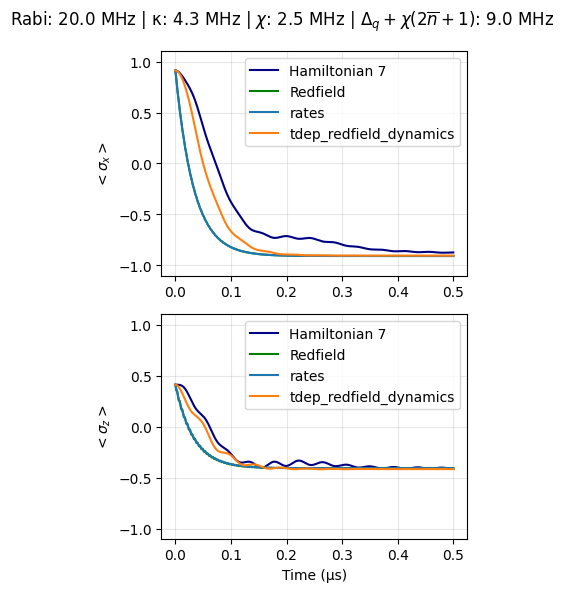

In [62]:
N = 10
cavity_diss_rate = 2*np.pi*4.3*10**6
input_power = 0
rabi_freq = 2*np.pi*20*10**6
eff_coupling = 2*np.pi*(2.5)*10**6
qubit_targetz = 9*2*np.pi*10**6
norm = eff_coupling
final_time__mus = 0.5
time_steps = 1000
tlist = np.linspace(0, final_time__mus, time_steps)

parameters = {"N":N,
            "final_time__mus": final_time__mus,
            "time_steps": time_steps,
            "input_power": input_power,
            "rabi_freq": rabi_freq,
            "eff_coupling": eff_coupling,
            "qubit_targetz": qubit_targetz,
            "cavity_diss_rate": cavity_diss_rate,
            "norm": norm}

H_qubit_target = target_hamiltonian(parameters)
eigenenergies, eigenstate = H_qubit_target.eigenstates()
psi0_atom = eigenstate[-1]
target_state = eigenstate[0]

parameters["initial_state_qubit"] = psi0_atom

full_dynamics = calculate_full_dynamics(parameters)

redfield_dynamics = calculate_redfield_dynamics(parameters)

rates_dynamics = calculate_rates_dynamics(parameters)

tdep_redfield_dynamics = calculate_tdep_redfield_dynamics(parameters)

x_tdep_redfield = expect(sigmax(), tdep_redfield_dynamics)
z_tdep_redfield = expect(sigmaz(), tdep_redfield_dynamics)

dynamics_dict = {'Hamiltonian 7': full_dynamics,
                  'Redfield': redfield_dynamics, 
                  'rates': rates_dynamics,
                  'tdep_redfield_dynamics': tdep_redfield_dynamics}

params_text = []

params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f} MHz")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\Delta_q+\chi (2\overline{n}+1)$"+f": {qubit_targetz/(2*np.pi*1e6):.1f} MHz")

plot_dynamics_comparison(tlist, dynamics_dict, params_text, max_time=None)

In [50]:
def calculate_old_rates_dynamics(parameters):

    #Retrieve needed parameters from the dictionary.
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']


    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    theta = np.arctan2(rabi_freq,qubit_detuning_lamb_shift)
    S_nn_neg = (cavity_photon_number * cavity_diss_rate) / ((cavity_diss_rate/2)**2+(rabi_freq/np.sin(theta) + cavity_detuning)**2)
    eff_qubit_excitation_rate = eff_coupling**2*S_nn_neg*np.sin(theta)**2
    S_nn_pos = (cavity_photon_number * cavity_diss_rate) / ((cavity_diss_rate/2)**2+(-rabi_freq/np.sin(theta) + cavity_detuning)**2)
    eff_qubit_decay_rate = eff_coupling**2*S_nn_pos*np.sin(theta)**2 


    #Norm everything
    tlist__N = tlist*norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    eff_qubit_excitation_rate__N = eff_qubit_excitation_rate/norm
    eff_qubit_decay_rate__N = eff_qubit_decay_rate/norm

    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = 5*diag_qubit_freq__N*sz_matrix

    dissipation_channels = [eff_qubit_excitation_rate__N**.5*sm_matrix.T, eff_qubit_decay_rate__N**.5*sm_matrix]

    U = unitary_diag_qubit_hamiltonian(parameters)

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, eff_qubit_excitation_rate__N, eff_qubit_decay_rate__N,])

    sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                     t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, dissipation_channels))
    
    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics

[[10, 2], [10, 2]]
[[2], [2]]
[[2], [2]]
[[2], [2]]


(<Figure size 400x600 with 2 Axes>,
 array([<Axes: ylabel='$<\\sigma_x>$'>,
        <Axes: xlabel='Time (μs)', ylabel='$<\\sigma_z>$'>], dtype=object))

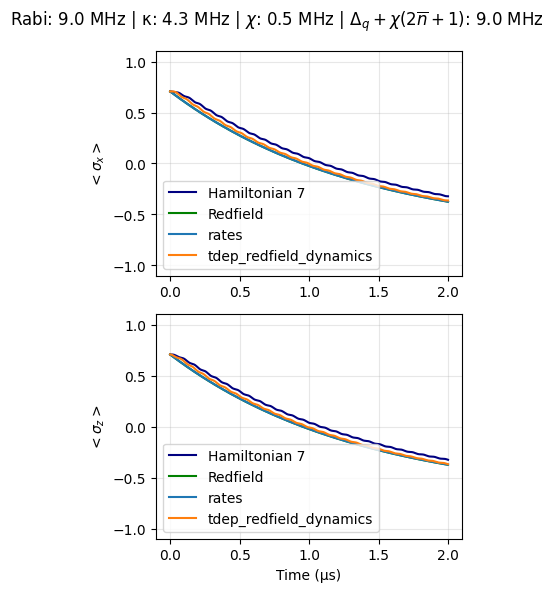

In [56]:
old_rates_dynamics = calculate_old_rates_dynamics(parameters)
rates_dynamics = calculate_rates_dynamics(parameters)

dynamics_dict = {'Hamiltonian 7': full_dynamics,
                  'Redfield': redfield_dynamics, 
                  'rates': rates_dynamics,
                  'tdep_redfield_dynamics': tdep_redfield_dynamics}


plot_dynamics_comparison(tlist, dynamics_dict, params_text, max_time=None)